# Project 2 report

## Group information

---

**Group number:** 15

**Group member:**

Zhao Zhixuan s2207051

Zhao Xinzhe s2257473

Dai Tingting s2113129

## Introduction

---

* **Why we care?**

Nothing is more important to life than breathing: in a lifetime, about 250 million liters of air pass through your lungs. Air pollution is now the biggest environmental risk for premature deaths, accounting for one in nine of all deaths. It kills 7 million people a year, far more than HIV, tuberculosis and malaria combined. Air pollution is the result of gas and particle emissions and their chemical reactions in the atmosphere. Pollutants with significant public health implications include particulate matter, carbon monoxide, ozone, nitrogen dioxide and sulphur dioxide.

In order to reduce the emission of these pollutants, more and more countries have promulgated national air quality laws and related policies to control air pollution. On a global scale, Europe region is the most effective in combating environmental pollution. **This project focuses on Germany, a typical EU country, for air pollution analysis**.

<center>
<img src="https://drive.google.com/uc?id=1t2LXZ0MT6uFjbLpBSG6tbxEQlxHU_z08" width=45% height=50% />
</center>

* **Why these data?**

In order to ensure the completeness and consistency of the report, this project focuses on **Berlin**, the city with the most comprehensive data, as the subject of analysis. After exploring the data, it was found that there are various ways to calculate the **Air quality index(AQI)**, which usually includes three main pollutants: **nitrogen dioxide(NO2), sulphur dioxide(SO2) and PM10**. Therefore, in this paper, these three pollutants are used to measure the air quality in Berlin.


* **What are we doing?**

In this project, the data for Germany and Berlin are queried from Openaq and presented according to our requirements. Then, the data are processed to show **annual trends** in nitrogen dioxide concentrations in Berlin. The trends evident in the graphs lead us to two conjectures. One is that the data from **different weather stations** cause fluctuations in pollutant concentrations, and the other is that weather factors have a large influence on pollutant concentrations. We will test both conjectures in turn in the following. Finally, the findings on air pollutants in Berlin, Germany, will be presented.
 
 

## A preliminary understanding of our data

---

### Set everything up
    
Before doing our data calls and then exploring it, we import all the modules required later at the beginning and changed the openaq version to V2.

We've implemented the installation: `pip install meteostat` and `pip install sklearn`


In [3]:
import openaq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from datetime import datetime
from meteostat import Hourly
from meteostat import Point
from meteostat import Stations
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
warnings.simplefilter('ignore')

In [3]:
api = openaq.OpenAQ(version='v2')

### Get to know about Berlin, Germany
    
After setting it up, we should start by checking some basic information of the city and country we want to investigate (that is **Berlin, Germany**) to make sure our investigation is on track.

In order to do this, we need to make three separate requests.

In [4]:
resp1 = api.countries(df=True)
resp1.query("name == 'Germany'")

,code,name,locations,firstUpdated,lastUpdated,parameters,count,cities,sources
33,DE,Germany,518,2016-11-21 11:00:00+00:00,2021-02-01 13:30:01+00:00,"[co, no2, o3, pm1, pm10, pm25, so2, um010, um0...",90966420806,23,4


In [5]:
resp2 = api.cities(country = 'DE', df=True)
resp2.query("city == 'Berlin'")

,country,city,count,locations,firstUpdated,lastUpdated,parameters
3,DE,Berlin,74542309,16,2016-11-21 11:00:00+00:00,2021-02-01 01:00:00+00:00,"[co, no2, o3, pm10, so2]"


In [6]:
resp3 = api.locations(country = 'DE', city = 'Berlin', df=True)
resp3.head(3)

# resp1.to_csv('Germany_details.csv', index=False)
# resp2.to_csv('Berlin_details.csv', index=False)
# resp3.to_csv('Berlin_location_details.csv', index=False)

,id,city,name,entity,country,sources,isMobile,isAnalysis,parameters,sensorType,lastUpdated,firstUpdated,measurements,coordinates.latitude,coordinates.longitude
0,2993,Berlin,DEBE034,government,DE,"[{'id': 'eea', 'url': 'http://www.eea.europa.e...",False,False,"[{'id': 1300115, 'unit': 'µg/m³', 'count': 166...",reference grade,2021-12-09 01:00:00+00:00,2016-11-21 11:00:00+00:00,77849,52.489451,13.430844
1,3017,Berlin,DEBE066,government,DE,"[{'id': 'eea', 'url': 'http://www.eea.europa.e...",False,False,"[{'id': 6416, 'unit': 'µg/m³', 'count': 15749,...",reference grade,2021-12-09 01:00:00+00:00,2016-11-21 11:00:00+00:00,40768,52.485296,13.529504
2,3019,Berlin,DEBE068,government,DE,"[{'id': 'eea', 'url': 'http://www.eea.europa.e...",False,False,"[{'id': 1300119, 'unit': 'µg/m³', 'count': 164...",reference grade,2021-12-09 01:00:00+00:00,2016-11-21 11:00:00+00:00,52206,52.513606,13.418833


The three tables above give us as much background information as we need. So we now know:

* Germany's code is DE, which we will need later in requesting the data of pollutants.
* Berlin has 16 locations and holds the parameters that we want.(NO2, SO2, PM10)
* Some detailed information about Berlin's 16 locations like their id, name, parameters and coordinates.

## Start with NO2 and take a peek of it

---

We could now officially start our investigation after handeling the basic information of Berlin, Germany.
We began to request the data that are truely assiociate with different pollutants, which we care most. Notice that the pollutants we chose to investigate were **NO2, SO2 and PM10**.

The code below helps us collect the data of **pollutant item——NO2 in every location of Berlin** during the whole year of 2020. We present the top ten rows for us to look at.

Note:
* We separately request the data of each pollutant item in order to avoid unexpected data loss during the request process.
* Calendar year was selected as the survey cycle to avoid the influence of seasonal factors on the results. 

In [7]:
# request the data of pollutant NO2 and do some pre-process on our data
AQ_Germany_BL_no2 = api.measurements(country='DE',city='Berlin',parameter='no2', limit=40000, date_from = '2020-01-01', date_to = '2020-12-31', df=True)
AQ_Germany_BL_no2 = AQ_Germany_BL_no2.query("value >= 0.0")
AQ_Germany_BL_no2.sort_values(by=['date.utc'], ascending=True, inplace=True)
AQ_Germany_BL_no2['mydate'] = pd.to_datetime(AQ_Germany_BL_no2['date.utc'].dt.date)
AQ_Germany_BL_no2['mymonth'] = AQ_Germany_BL_no2['mydate'].dt.month

# use to_csv to store our data
# AQ_Germany_BL_no2.to_csv('AQ_Germany_BL_no2.csv', index=False)

In [8]:
AQ_Germany_BL_no2.head(10)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,coordinates.latitude,coordinates.longitude,mydate,mymonth
date.local,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,4769,DEBE051,no2,7.35,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.643525,13.489531,2020-01-01,1
2020-01-01 01:00:00,4767,DEBE065,no2,3.41,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.514072,13.469931,2020-01-01,1
2020-01-01 01:00:00,3021,DEBE064,no2,66.68,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.481709,13.433967,2020-01-01,1
2020-01-01 01:00:00,4765,DEBE067,no2,51.36,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.506600,13.332972,2020-01-01,1
2020-01-01 01:00:00,3025,DEBE063,no2,64.08,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.467534,13.441654,2020-01-01,1
2020-01-01 01:00:00,4763,DEBE027,no2,13.41,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.398406,13.368103,2020-01-01,1
2020-01-01 01:00:00,3019,DEBE068,no2,48.58,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.513606,13.418833,2020-01-01,1
2020-01-01 01:00:00,3026,DEBE018,no2,47.92,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.485814,13.348775,2020-01-01,1
2020-01-01 01:00:00,4762,DEBE061,no2,58.43,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.463611,13.318250,2020-01-01,1


It is not difficult to see from the above table that we have obtained all the data needed for the investigation (of NO2). From now on, all our explorations will revolve around the data in the table above, and we will try to extract as much information as possible from the data given above from various perspective.

### Investigate NO2 concentrations at a single location


Since we have NO2 data for a whole year, it's not surprising that we want to know the distribution of NO2 concentration during a year. This is at least the first thing we should do if we want to explore more!

However, the concentration of NO2 varies from place to place depending on geography and other factors, and if we looked blindly at all the places (which is the crude data we have) we might not get any useful information. (Or worse, we'll be misled.)
So why don't we pick a specific location to explore first? Therefore, we randomly select the `Location: DEBE034` and visualize its NO2 concentration during the year.


Text(0.5, 1.0, 'Distribution of NO2 concentration in DEBE034 during 2020')

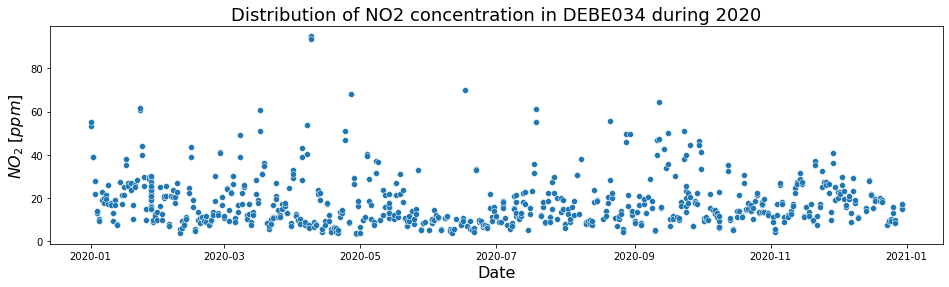

In [9]:
DEBE034_no2 = AQ_Germany_BL_no2.query("location == 'DEBE034'")

fig, ax = plt.subplots(figsize=(16,4))
ax = sns.scatterplot(data = DEBE034_no2, x='mydate', y='value')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel("$NO_2 \; [ppm]$", fontsize=16)
ax.set_title('Distribution of NO2 concentration in DEBE034 during 2020', fontsize=18)

Note: The vertical data in the figure represents several data monitored in a day, so that we can see the changes of data in a day.

From the figure above, we can see that:

Although some of the value fluctuates, most of the data are relatively concentrated, while a few values are relatively large and discrete. Meanwhile, its distribution also changes with time. 

In order to get a more accurate view of the data of `DEBE034`, we made some **numerical statistics** on NO2 value, and the results are shown as follows.

In [10]:
DEBE034_no2_des = DEBE034_no2['value'].describe()
DEBE034_no2_min = DEBE034_no2_des.loc['min']
DEBE034_no2_max = DEBE034_no2_des.loc['max']
DEBE034_no2_09p = DEBE034_no2['value'].quantile(0.9)

print(DEBE034_no2_des)
print('\nIt can be seen from the table above:\nThe highest concentration of NO2 in the location DEBE034 is {:.2f}.'.format(DEBE034_no2_max))
print('The lowest concentration of NO2 in the location DEBE034 is {:.2f}.'.format(DEBE034_no2_min))
print('90% of the concentration of NO2 is below {:.2f}.'.format(DEBE034_no2_09p))

count    684.000000
mean      18.132939
std       11.859390
min        3.470000
25%       10.115000
50%       15.005000
75%       22.362500
max       94.850000
Name: value, dtype: float64

It can be seen from the table above:
The highest concentration of NO2 in the location DEBE034 is 94.85.
The lowest concentration of NO2 in the location DEBE034 is 3.47.
90% of the concentration of NO2 is below 32.24.


**Now let's do some more interesting statistics.**

For example, how does the distribution of NO2 values depend on its month?

To do that, we can use the barplot in seaborn, which gives us an intuitive and clear statistical plot.

Text(0.5, 1.0, 'Distribution of NO2 concentration in DEBE034 in twelve months')

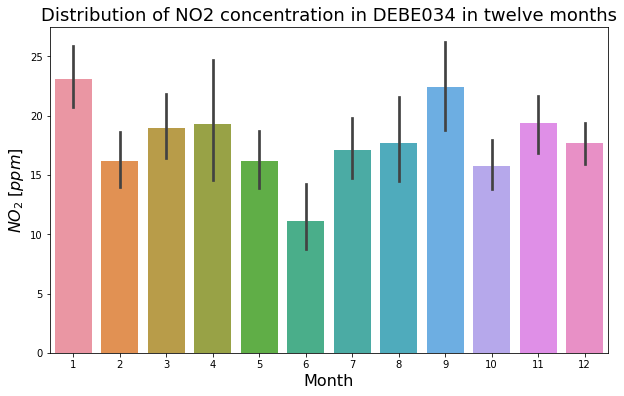

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x='mymonth', y='value', data=DEBE034_no2)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel("$NO_2 \; [ppm]$", fontsize=16)
ax.set_title('Distribution of NO2 concentration in DEBE034 in twelve months', fontsize=18)

As our expect (guessed from the first figure), the concentration of NO2 in summer, especially In June, significantly decreased, while its concentration reaches the highest in January and September.

### Look at the whole area of Berlin


So far, we have draw some conclusions on the `Location: DEBE034`. On this basis, we want to know if there is a similar pattern in other locations.

We visualized the concentration values of NO2 in every locations in Berlin during the whole year. We use catplot to generate all the plots at once for easy observation.

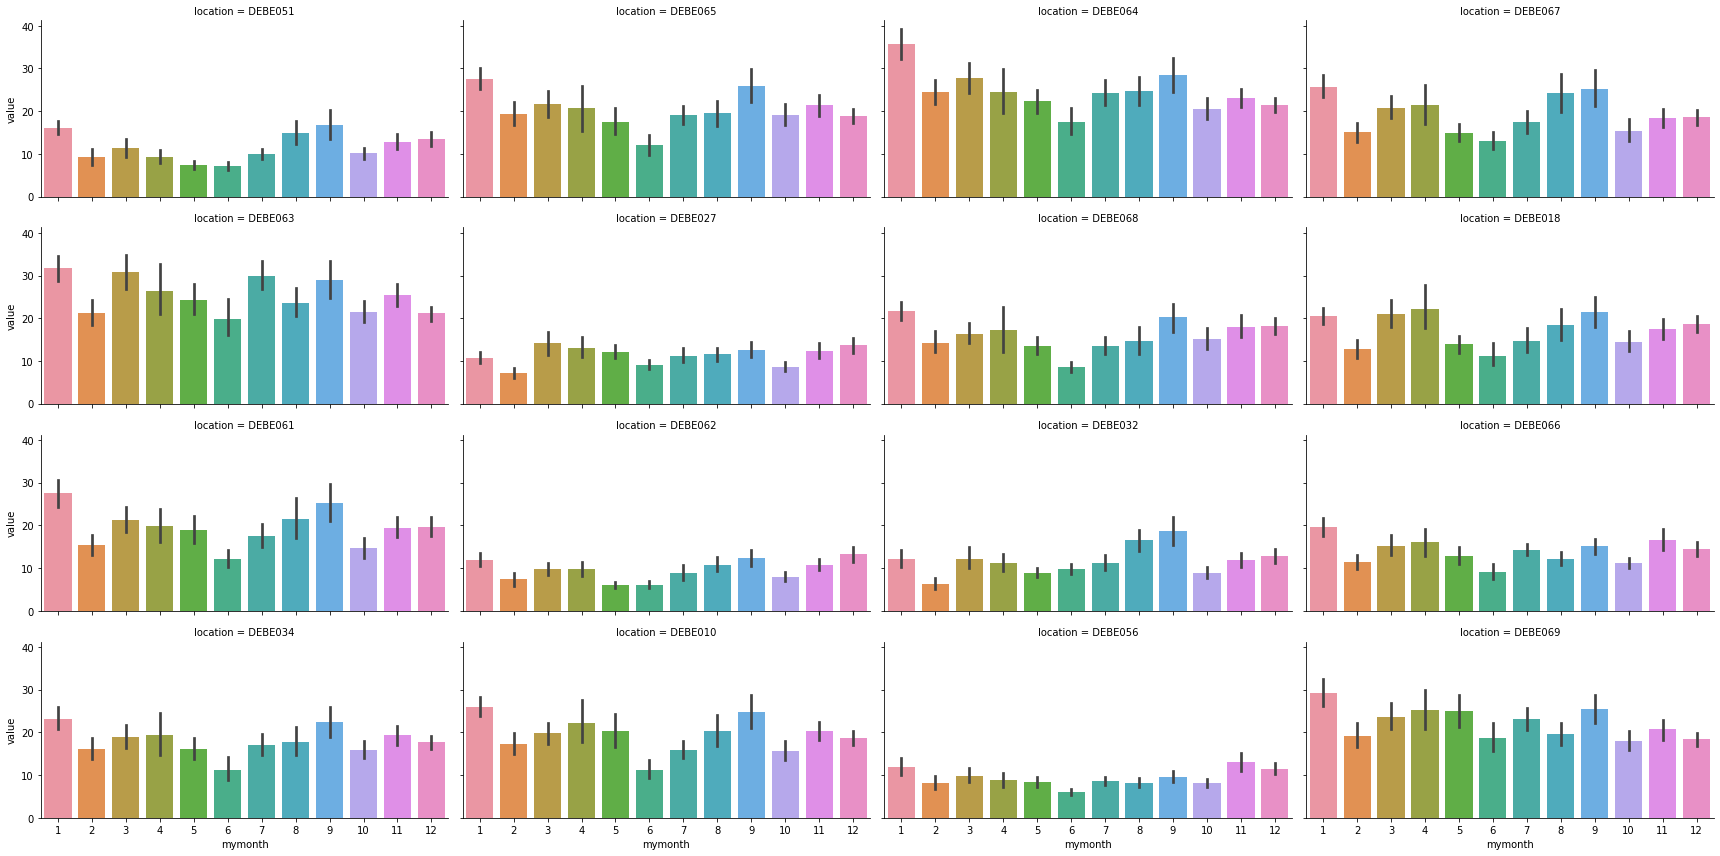

In [12]:
g3 = sns.catplot(data=AQ_Germany_BL_no2,         
                 x='mymonth',y='value',   
                 col='location',col_wrap=4,
                 kind='bar',height=3, aspect=2)
plt.show()

From the above 12 figures, we can clearly know that:

* It is true in all locations that NO2 concentration will decrease slightly in summer and increase relatively in spring and autumn.

* The distribution of NO2 in each location is not completely consistent.

* Therefore, we believe that subsequent exploration should be focused on each location to avoid the impact of regional differences.

## Take SO2, PM10 into account

---

So far, it seems that we have forgotten our parameters SO2, PM10, although this is not the case. We just explored the distribution of the concentration of a single pollutant using NO2 as an example. What we do above can completely put into **SO2 and PM10**.

We now want to do some thing more interesting, which means we need more data!

Thus, the seperate exploration of NO2 is end for now, and we take SO2 and PM10 into our investigation.



In [13]:
# request the data of SO2, PM10 respectively and do some regular preprocess
AQ_Germany_BL_so2 = api.measurements(country='DE',city='Berlin',parameter='so2', limit=10000, date_from = '2020-01-01', date_to = '2020-12-31', df=True)
AQ_Germany_BL_so2 = AQ_Germany_BL_so2.query("value >= 0.0")
AQ_Germany_BL_so2.sort_values(by=['date.utc'], ascending=True, inplace=True)
AQ_Germany_BL_so2['mydate'] = pd.to_datetime(AQ_Germany_BL_so2['date.utc'].dt.date)
AQ_Germany_BL_so2['mymonth'] = AQ_Germany_BL_so2['mydate'].dt.month
# AQ_Germany_BL_so2.to_csv('AQ_Germany_BL_so2.csv', index=False)

AQ_Germany_BL_pm10 = api.measurements(country='DE',city='Berlin',parameter='pm10', limit=30000, date_from = '2020-01-01', date_to = '2020-12-31', df=True)
AQ_Germany_BL_pm10 = AQ_Germany_BL_pm10.query("value >= 0.0")
AQ_Germany_BL_pm10.sort_values(by=['date.utc'], ascending=True, inplace=True)
AQ_Germany_BL_pm10['mydate'] = pd.to_datetime(AQ_Germany_BL_pm10['date.utc'].dt.date)
AQ_Germany_BL_pm10['mymonth'] = AQ_Germany_BL_pm10['mydate'].dt.month 
# AQ_Germany_BL_pm10.to_csv('AQ_Germany_BL_pm10.csv', index=False)

In [14]:
AQ_Germany_BL_so2.head(5)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,coordinates.latitude,coordinates.longitude,mydate,mymonth
date.local,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,4767,DEBE065,so2,222.64,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.514072,13.469931,2020-01-01,1
2020-01-01 02:00:00,4767,DEBE065,so2,27.79,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 01:00:00+00:00,52.514072,13.469931,2020-01-01,1
2020-01-02 01:00:00,4767,DEBE065,so2,2.25,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-02 00:00:00+00:00,52.514072,13.469931,2020-01-02,1
2020-01-02 02:00:00,4767,DEBE065,so2,1.96,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-02 01:00:00+00:00,52.514072,13.469931,2020-01-02,1
2020-01-03 01:00:00,4767,DEBE065,so2,2.52,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-03 00:00:00+00:00,52.514072,13.469931,2020-01-03,1


In [15]:
AQ_Germany_BL_pm10.head(5)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,coordinates.latitude,coordinates.longitude,mydate,mymonth
date.local,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,3025,DEBE063,pm10,547.17,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.467534,13.441654,2020-01-01,1
2020-01-01 01:00:00,4764,DEBE069,pm10,750.62,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.438115,13.387720,2020-01-01,1
2020-01-01 01:00:00,4769,DEBE051,pm10,39.06,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.643525,13.489531,2020-01-01,1
2020-01-01 01:00:00,3021,DEBE064,pm10,303.55,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.481709,13.433967,2020-01-01,1
2020-01-01 01:00:00,4582,DEBE032,pm10,31.61,b'\xc2\xb5g/m\xc2\xb3',DE,Berlin,False,False,government,reference grade,2020-01-01 00:00:00+00:00,52.473192,13.225144,2020-01-01,1


### Synthesize all the data


Until now we really own all the data we need(not just NO2!)

**Since the data is stored separately in three Dataframes, we might want to combine them for further exploration.** Considering that there are too many data (different pollutant concentrations on the same day), we wish to filter out data that is more representative than others to simplify our Dataframe. Here, we choose the **mean, maximum and minimum**, because those are what we think most important and have generalized significance. 

Note: as we said before, we take different location into account, so we add a column for different locations.

In [16]:
# Daily mean, minimum, maximum
AQ_Germany_BL = pd.DataFrame()

# NO2
AQ_Germany_BL_no2_sts = AQ_Germany_BL_no2.copy()
AQ_Germany_BL['latitude'] = AQ_Germany_BL_no2_sts.groupby(['mydate','location'])['coordinates.latitude'].unique()
AQ_Germany_BL['longitude'] = AQ_Germany_BL_no2_sts.groupby(['mydate','location'])['coordinates.longitude'].unique()
AQ_Germany_BL['latitude'] = AQ_Germany_BL['latitude'].astype(float, errors = 'raise')
AQ_Germany_BL['longitude'] = AQ_Germany_BL['longitude'].astype(float, errors = 'raise')
AQ_Germany_BL['NO2_min'] = AQ_Germany_BL_no2_sts.groupby(['mydate','location'])['value'].min()
AQ_Germany_BL['NO2_max'] = AQ_Germany_BL_no2_sts.groupby(['mydate','location'])['value'].max()
AQ_Germany_BL['NO2_avg'] = AQ_Germany_BL_no2_sts.groupby(['mydate','location'])['value'].mean()
# SO2
AQ_Germany_BL_so2_sts = AQ_Germany_BL_so2.copy()
AQ_Germany_BL['SO2_min'] = AQ_Germany_BL_so2_sts.groupby(['mydate','location'])['value'].min()
AQ_Germany_BL['SO2_max'] = AQ_Germany_BL_so2_sts.groupby(['mydate','location'])['value'].max()
AQ_Germany_BL['SO2_avg'] = AQ_Germany_BL_so2_sts.groupby(['mydate','location'])['value'].mean()
# PM10
AQ_Germany_BL_pm10_sts = AQ_Germany_BL_pm10.copy()
AQ_Germany_BL['PM10_min'] = AQ_Germany_BL_pm10_sts.groupby(['mydate','location'])['value'].min()
AQ_Germany_BL['PM10_max'] = AQ_Germany_BL_pm10_sts.groupby(['mydate','location'])['value'].max()
AQ_Germany_BL['PM10_avg'] = AQ_Germany_BL_pm10_sts.groupby(['mydate','location'])['value'].mean()
# Use 'mydate' and 'location' as columns instead of indexes
AQ_Germany_BL = AQ_Germany_BL.rename_axis(['mydate','location']).reset_index()
AQ_Germany_BL.head(5)

,mydate,location,latitude,longitude,NO2_min,NO2_max,NO2_avg,SO2_min,SO2_max,SO2_avg,PM10_min,PM10_max,PM10_avg
0,2020-01-01,DEBE010,52.543041,13.349326,49.56,52.07,50.815,NaN,NaN,NaN,56.70,83.81,70.255
1,2020-01-01,DEBE018,52.485814,13.348775,30.72,47.92,39.320,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,DEBE027,52.398406,13.368103,13.41,28.51,20.960,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,DEBE032,52.473192,13.225144,4.72,10.82,7.770,NaN,NaN,NaN,31.61,70.70,51.155
4,2020-01-01,DEBE034,52.489451,13.430844,53.56,55.19,54.375,NaN,NaN,NaN,180.33,208.22,194.275


### The distribution of average concentration values

First, we want to see the distribution of average concentration values of pollution in a year, so we use displot in seaborn to draw a histogram of NO2 values.

At present, we don't split location specifically, but statistics the concentration of NO2 in the whole Berlin.

As can be seen in the figure below, the concentration of NO2 might approximately be distributed in chi square, that is, **most values are concentrated between 0 and 30, but the tail is very long**.

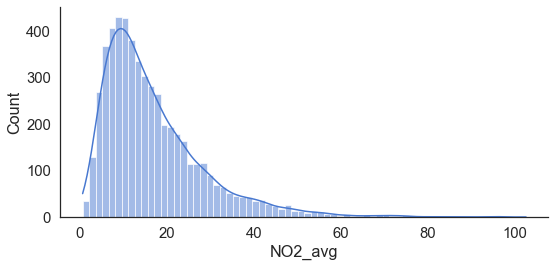

In [17]:
sns.set(style="white", palette='muted', font_scale=1.35, color_codes=True)
g4 = sns.displot(data=AQ_Germany_BL, x='NO2_avg', kde=True, height=4, aspect=2)

As we said, the plot above doesn't take into account the regional impact (different locations). So is this an arbitrary superposition of different distributions of all locations? We wanted to know if that was the case.

Let's take a look at each location separately.

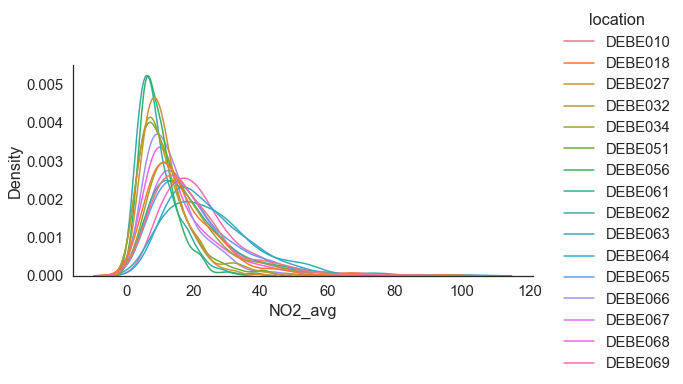

In [18]:
g5 = sns.displot(data=AQ_Germany_BL, x='NO2_avg', hue='location', kind='kde', height=4, aspect=2)

From the figure above we know that: Although their parameters are different, they are all approximately chi-square. Meanwhile, their peak values are all between 0 and 20, and a small part of the data is in a discrete state with other data. 

##  Evaluate the AQI (air quality index) in Berlin

---

Since we now have consolidated data on three pollutants, we can use that data to evaluate the **air quality** in Berlin.

There are several steps needed to accomplish this. First, the average daily concentrations of NO2, SO2 and PM10 were respectively converted into **individual air quality index (IAQI)**, and then the AQI was obtained from the three IAQI. 

Note that: Air quality index and corresponding pollutant project concentration limit: https://blog.csdn.net/kexiiii/article/details/119535019
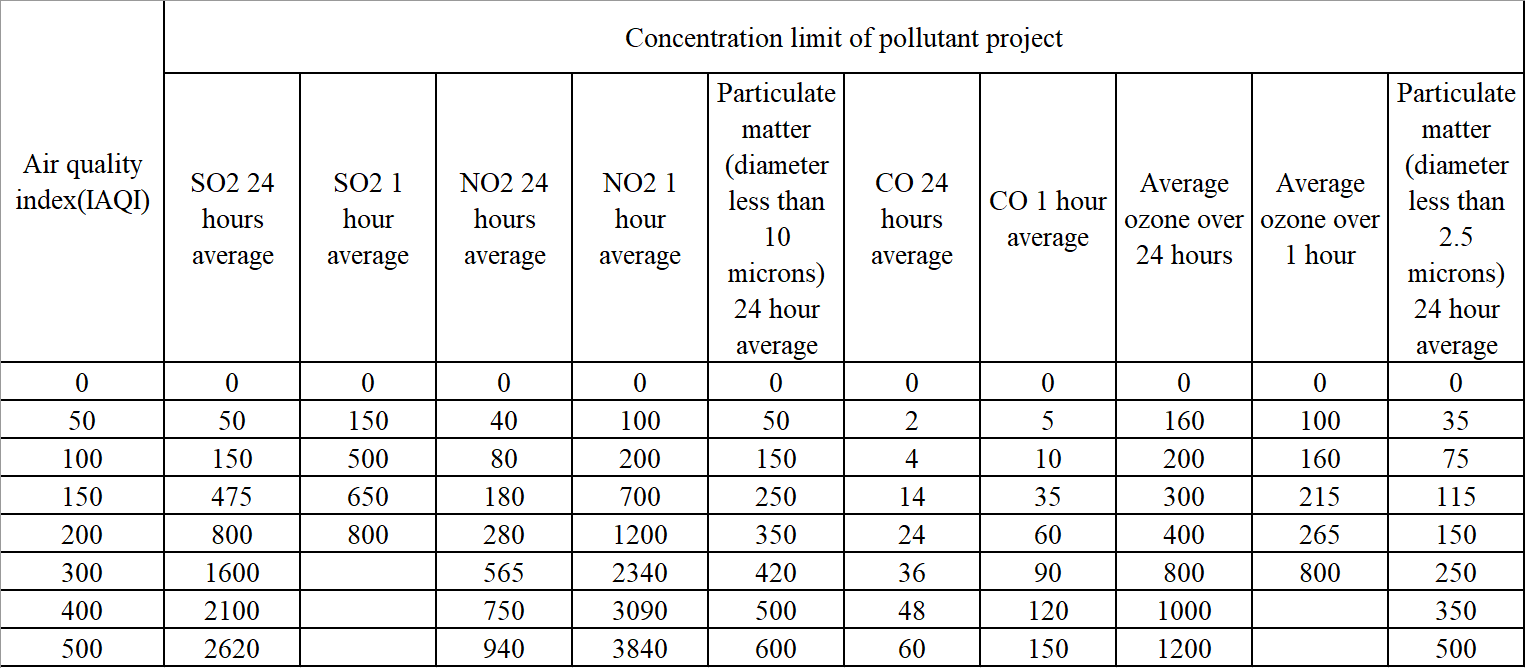

In [19]:
def AQI_calculate(target_h,target_l,object_h,object_l,object_c):
    '''
    Calculate the individual air quality index corresponding to pollutants according to the 'air quality index' table.

    Input:  object_c: The concentration value of pollutant item 
            object_h: The upper limit value near to the concentration of the pollutant
            object_l: The low limit value near to the concentration of the pollutant
            target_h: The individual air quality index corresponding to the object_h
            target_l: The individual air quality index corresponding to the object_l
    
    Output: target_c: The individual air quality index corresponding to pollutants
    '''
    target_c = (target_h-target_l)/(object_h-object_l)*(object_c-object_l) + target_l
    return target_c

def SO2_AQI(object_c):
    '''
    Calculate the individual air quality index corresponding to pollutants according to the specific parameters of so2 in the 'air quality index' table.

    Input:  object_c: The concentration value of so2
    
    Output: so2_aqi: The individual air quality index of so2
    '''
    if 0 <= object_c and object_c < 50:
        [target_h,target_l,object_h,object_l] = [50,0,50,0]
    elif 50 <= object_c and object_c < 150:
        [target_h,target_l,object_h,object_l] = [100,50,150,50]
    elif 150 <= object_c and object_c < 475:
        [target_h,target_l,object_h,object_l] = [150,100,475,150]
    elif 475 <= object_c and object_c < 800:
        [target_h,target_l,object_h,object_l] = [200,150,800,475]
    elif 800 <= object_c and object_c < 1600:
        [target_h,target_l,object_h,object_l] = [300,200,1600,800]
    elif 1600 <= object_c and object_c < 2100:
        [target_h,target_l,object_h,object_l] = [400,300,2100,1600]
    elif 2100 <= object_c and object_c < 2620:
        [target_h,target_l,object_h,object_l] = [500,400,2620,2100]
    else:
        pass

    if np.isnan(object_c):
        so2_aqi = 0
    else:
        so2_aqi = AQI_calculate(target_h,target_l,object_h,object_l,object_c)
    return so2_aqi

def NO2_AQI(object_c):
    '''
    Calculate the individual air quality index corresponding to pollutants according to the specific parameters of no2 in the 'air quality index' table.

    Input:  object_c: The concentration value of no2
    
    Output: no2_aqi: The individual air quality index of no2
    '''
    if 0 <= object_c and object_c < 40:
        [target_h,target_l,object_h,object_l] = [50,0,40,0]
    elif 40 <= object_c and object_c < 80:
        [target_h,target_l,object_h,object_l] = [100,50,80,40]
    elif 80 <= object_c and object_c < 180:
        [target_h,target_l,object_h,object_l] = [150,100,180,80]
    elif 180 <= object_c and object_c < 280:
        [target_h,target_l,object_h,object_l] = [200,150,280,180]
    elif 280 <= object_c and object_c < 565:
        [target_h,target_l,object_h,object_l] = [300,200,565,280]
    elif 565 <= object_c and object_c < 750:
        [target_h,target_l,object_h,object_l] = [400,300,750,565]
    elif 750 <= object_c and object_c < 940:
        [target_h,target_l,object_h,object_l] = [500,400,940,750]
    else:
        pass

    if np.isnan(object_c):
        no2_aqi = 0
    else:
        no2_aqi = AQI_calculate(target_h,target_l,object_h,object_l,object_c)
    return no2_aqi

def PM10_AQI(object_c):
    '''
    Calculate the individual air quality index corresponding to pollutants according to the specific parameters of pm10 in the 'air quality index' table.

    Input:  object_c: The concentration value of pm10
    
    Output: pm10_aqi: The individual air quality index of pm10
    '''
    if 0 <= object_c and object_c < 50:
        [target_h,target_l,object_h,object_l] = [50,0,50,0]
    elif 50 <= object_c and object_c < 150:
        [target_h,target_l,object_h,object_l] = [100,50,150,50]
    elif 150 <= object_c and object_c < 250:
        [target_h,target_l,object_h,object_l] = [150,100,250,150]
    elif 250 <= object_c and object_c < 350:
        [target_h,target_l,object_h,object_l] = [200,150,350,250]
    elif 350 <= object_c and object_c < 420:
        [target_h,target_l,object_h,object_l] = [300,200,420,350]
    elif 420 <= object_c and object_c < 500:
        [target_h,target_l,object_h,object_l] = [400,300,420,500]
    elif 500 <= object_c and object_c < 600:
        [target_h,target_l,object_h,object_l] = [500,400,500,600]
    else:
        pass

    if np.isnan(object_c):
        pm10_aqi = 0
    else:
        pm10_aqi = AQI_calculate(target_h,target_l,object_h,object_l,object_c)
    return pm10_aqi


In [20]:
AQ_Germany_BL['NO2_IAQI'] = AQ_Germany_BL['NO2_avg'].map(lambda x: NO2_AQI(x))
AQ_Germany_BL['SO2_IAQI'] = AQ_Germany_BL['SO2_avg'].map(lambda x: SO2_AQI(x))
AQ_Germany_BL['PM10_IAQI'] = AQ_Germany_BL['PM10_avg'].map(lambda x: PM10_AQI(x))
AQ_Germany_BL['AQI'] = AQ_Germany_BL[['NO2_IAQI', 'SO2_IAQI','PM10_IAQI']].max(axis=1)
AQ_Germany_BL.head(5)

,mydate,location,latitude,longitude,NO2_min,NO2_max,NO2_avg,SO2_min,SO2_max,SO2_avg,PM10_min,PM10_max,PM10_avg,NO2_IAQI,SO2_IAQI,PM10_IAQI,AQI
0,2020-01-01,DEBE010,52.543041,13.349326,49.56,52.07,50.815,NaN,NaN,NaN,56.70,83.81,70.255,63.51875,0.0,60.1275,63.51875
1,2020-01-01,DEBE018,52.485814,13.348775,30.72,47.92,39.320,NaN,NaN,NaN,NaN,NaN,NaN,49.15000,0.0,0.0000,49.15000
2,2020-01-01,DEBE027,52.398406,13.368103,13.41,28.51,20.960,NaN,NaN,NaN,NaN,NaN,NaN,26.20000,0.0,0.0000,26.20000
3,2020-01-01,DEBE032,52.473192,13.225144,4.72,10.82,7.770,NaN,NaN,NaN,31.61,70.70,51.155,9.71250,0.0,50.5775,50.57750
4,2020-01-01,DEBE034,52.489451,13.430844,53.56,55.19,54.375,NaN,NaN,NaN,180.33,208.22,194.275,67.96875,0.0,122.1375,122.13750


In [21]:
AQ_Germany_BL.query('mydate=="2020-01-01"')

,mydate,location,latitude,longitude,NO2_min,NO2_max,NO2_avg,SO2_min,SO2_max,SO2_avg,PM10_min,PM10_max,PM10_avg,NO2_IAQI,SO2_IAQI,PM10_IAQI,AQI
0,2020-01-01,DEBE010,52.543041,13.349326,49.56,52.07,50.815,NaN,NaN,NaN,56.70,83.81,70.255,63.51875,0.0000,60.12750,63.51875
1,2020-01-01,DEBE018,52.485814,13.348775,30.72,47.92,39.320,NaN,NaN,NaN,NaN,NaN,NaN,49.15000,0.0000,0.00000,49.15000
2,2020-01-01,DEBE027,52.398406,13.368103,13.41,28.51,20.960,NaN,NaN,NaN,NaN,NaN,NaN,26.20000,0.0000,0.00000,26.20000
3,2020-01-01,DEBE032,52.473192,13.225144,4.72,10.82,7.770,NaN,NaN,NaN,31.61,70.70,51.155,9.71250,0.0000,50.57750,50.57750
4,2020-01-01,DEBE034,52.489451,13.430844,53.56,55.19,54.375,NaN,NaN,NaN,180.33,208.22,194.275,67.96875,0.0000,122.13750,122.13750
5,2020-01-01,DEBE051,52.643525,13.489531,7.35,19.73,13.540,NaN,NaN,NaN,39.06,83.32,61.190,16.92500,0.0000,55.59500,55.59500
6,2020-01-01,DEBE056,52.447697,13.647050,30.97,47.55,39.260,NaN,NaN,NaN,111.51,111.51,111.510,49.07500,0.0000,80.75500,80.75500
7,2020-01-01,DEBE061,52.463611,13.318250,37.14,58.43,47.785,NaN,NaN,NaN,215.92,450.54,333.230,59.73125,0.0000,191.61500,191.61500
8,2020-01-01,DEBE062,52.653269,13.296081,6.79,8.03,7.410,NaN,NaN,NaN,NaN,NaN,NaN,9.26250,0.0000,0.00000,9.26250
9,2020-01-01,DEBE063,52.467534,13.441654,45.52,64.08,54.800,NaN,NaN,NaN,202.32,547.17,374.745,68.50000,0.0000,235.35000,235.35000


### Visualize the daily air quality in Berlin

After calculating the AQI data for every day of the year (in different locations) in Berlin, we were able to make comparison on the air quality in 16 locations of Berlin.

Here we choose a specific day `(2020-01-01)` to visualize the air quality in different locations on that day and form an intuitive comparison by using replot in seaborn.

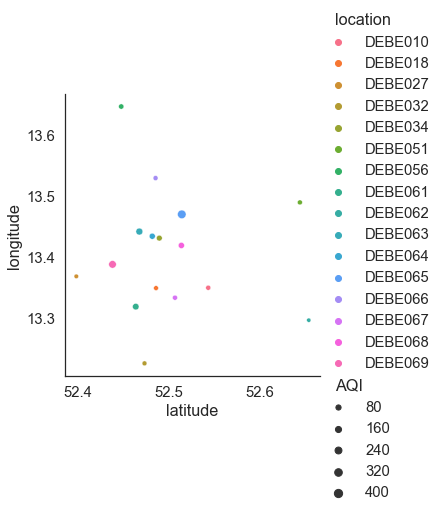

In [22]:
g6 = sns.relplot(data=AQ_Germany_BL.query('mydate=="2020-01-01"'),
                 kind='scatter',
                 x='latitude',
                 y='longitude',
                 hue='location',size='AQI')

**Notice that if the AQI value is high, the point indicating its position will be relatively large.**

Therefore, from the figure above, we could know that: The air quality of `Location: DEBE065` is significantly worse than that of other locations on the day `2020-01-01`.

We can easily change our code (for date) to get a comparison of air quality for any day in 2020 for the 16 locations in Berlin. So the `Location: DEBE065` doesn't always have the worst air quality (or maybe it does).

## What causes changes in pollutant concentrations?

---

We've looked at air quality in Berlin, Germany, in some depth. We also want to know whether it can be affected by other external factors, but this requires further external data. For example, as seen above, season has a great influence on the concentration of pollutants. Is it because of weather affected by season? We want to explore whether there is a linear relationship between weather and pollutants. In this project, three important factors are used to measure **weather conditions**: temperature, humidity and wind speed.

Here, we call the meteostat API as an auxiliary.

Based on the above processing of air pollution data, it is reasonable to guess that there will be other influencing factors affecting the concentration of air pollutants, since the concentration of pollutants varies in the same city. Next, we mainly study the influence of weather factors on pollutant concentration.We select **temperature, humidity and wind speed** as the three most important factors to explore the influence of weather on pollutant concentration, and consider the relationship between pollutant concentration and the three weather factors. Here, we only assume that there is a **simple linear relationship** between them. 

First, to explore the influence of weather factors on the concentration of pollutants in the air in Berlin, Germany, we called **meteostat** to obtain the data of related weather factors. According to Hourly functions, we input the required latitude and longitude to retrieve the weather data of the location.

In [23]:
# Set time period 
# Set location==Berlin
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31, 23, 59)
location = Point(52.52, 13.4049)

# Get daily data for Berlin
BL = Hourly(location, start, end)
BL = BL.normalize()
BL = BL.aggregate('1D')
BL = BL.fetch()

# Get hourly data for Berlin
BL_hour = Hourly(location, start, end)
BL_hour = BL_hour.fetch()


Secondly, according to the daily weather data of temperature, humidity and wind speed, the hourly data can be obtained by calling up the input latitude and longitude position according to the API.

In [24]:
# Daily data for Berlin (show first five rows)
BL.head(5)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-01-01,2.7,0.9,87.8,0.0,0.0,253.4,9.0,27.0,1033.1,92.0,2.0
2020-01-02,0.9,-3.2,76.3,0.0,0.0,194.7,6.2,20.0,1026.8,374.0,1.0
2020-01-03,4.6,2.9,88.4,4.3,0.0,215.8,15.3,54.0,1017.6,0.0,7.0
2020-01-04,4.1,1.9,85.4,5.7,0.0,279.7,22.8,63.0,1020.3,0.0,7.0
2020-01-05,1.8,-0.5,84.5,0.0,0.0,252.6,11.3,40.0,1032.6,99.0,4.0


In [25]:
# Hourly data for Berlin (show first five rows)
BL_hour.head(5)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-01-01 00:00:00,4.4,1.4,81.0,0.0,0.0,270.0,9.4,16.0,1033.6,0.0,2.0
2020-01-01 01:00:00,3.5,1.5,87.0,0.0,NaN,270.0,11.2,18.0,1033.3,0.0,2.0
2020-01-01 02:00:00,2.8,1.3,90.0,0.0,NaN,280.0,10.4,19.0,1033.7,0.0,2.0
2020-01-01 03:00:00,2.4,1.2,92.0,0.0,NaN,260.0,9.0,15.0,1033.7,0.0,2.0
2020-01-01 04:00:00,3.1,1.8,91.0,0.0,NaN,270.0,9.4,17.0,1033.9,0.0,2.0


Note that：coco represents weather condition code：https://dev.meteostat.net/docs/formats.html#weather-condition-codes

### Synthesize all the data
We now have data on temperature, humidity, wind speed and barometric pressure for Berlin for every hour of every day in 2020. We would like to select the three main influences we mentioned above and aggregate the data on a daily basis. By presenting the **maximum, minimum and average values**, we want to preserve the characteristics of the data to a greater extent.

In [26]:
# Daily mean, minimum, maximum
BL_year = BL_hour.copy()
BL_year = BL_year.rename_axis('time').reset_index()
BL_year['date'] = BL_year['time'].dt.date
M_Germany_BL = pd.DataFrame()
# Get "Temperature" data
M_Germany_BL['temp_min'] = BL_year.groupby('date')['temp'].min()
M_Germany_BL['temp_max'] = BL_year.groupby('date')['temp'].max()
M_Germany_BL['temp_mean'] = BL_year.groupby('date')['temp'].mean()
# Get "Wind speed" data
M_Germany_BL['wsdp_min'] = BL_year.groupby('date')['wspd'].min()
M_Germany_BL['wspd_max'] = BL_year.groupby('date')['wspd'].max()
M_Germany_BL['wspd_mean'] = BL_year.groupby('date')['wspd'].mean()
# Get "Humidity" data
M_Germany_BL['rhum_min'] = BL_year.groupby('date')['rhum'].min()
M_Germany_BL['rhum_max'] = BL_year.groupby('date')['rhum'].max()
M_Germany_BL['rhum_mean'] = BL_year.groupby('date')['rhum'].mean()

M_Germany_BL

,temp_min,temp_max,temp_mean,wsdp_min,wspd_max,wspd_mean,rhum_min,rhum_max,rhum_mean
date,,,,,,,,,
2020-01-01,-1.3,5.6,2.733333,4.7,15.8,9.041667,76.0,94.0,87.750000
2020-01-02,-2.8,6.7,0.875000,3.2,9.4,6.162500,48.0,97.0,76.291667
2020-01-03,1.5,7.2,4.641667,9.4,30.6,15.254167,78.0,96.0,88.375000
2020-01-04,2.3,5.6,4.150000,17.6,31.7,22.783333,79.0,92.0,85.416667
2020-01-05,-0.5,3.8,1.845833,6.8,24.8,11.316667,77.0,93.0,84.500000
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.1,2.2,1.625000,16.6,25.9,21.295833,50.0,76.0,62.208333
2020-12-28,1.6,4.3,2.837500,4.3,18.7,13.250000,61.0,90.0,76.208333
2020-12-29,0.2,4.1,2.337500,5.0,14.4,9.758333,81.0,94.0,87.916667


Obviously the 'coco' in the hourly data, which represents the weather conditions, cannot be processed by means of a maximum or minimum value.

Let's count what kind of weather occurs most often in Berlin during the year. Is it sunny or rainy? First of all, a table of codes against weather conditions will be shown to help us read it more smoothly.

In [27]:
# Weather condition code
# Conduct a dataframe to store Weather Condition Codes
vals=['Clear','Fair','Cloudy','Overcast','Fog','Freezing Fog','Light Rain','Rain','Heavy Rain','Freezing Rain','Heavy Freezing Rain','Sleet','Heavy Sleet','Light Snowfall','Snowfall','Heavy Snowfall','Rain Shower','Heavy Rain Shower','Sleet Shower','Heavy Sleet Shower','Snow Shower','Heavy Snow Shower','Lightning','Hail','Thunderstorm','Heavy Thunderstorm','Storm']
column_labels=['Code','Weather Condition']
code_weather=pd.DataFrame(data=vals, columns=['Weather Condition'])
code_weather

,Weather Condition
0,Clear
1,Fair
2,Cloudy
3,Overcast
4,Fog
5,Freezing Fog
6,Light Rain
7,Rain
8,Heavy Rain
9,Freezing Rain


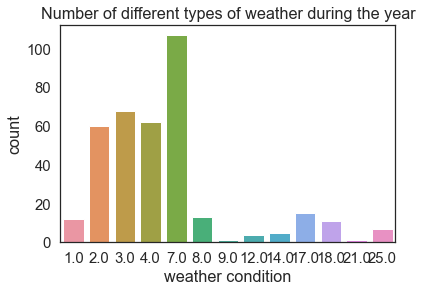

In [28]:
# Weather conditions during the year
sns.countplot(x='coco', data=BL)
plt.title('Number of different types of weather during the year')
plt.xlabel('weather condition')
plt.show()

As we can see from the graph above, rainy days are the most common weather in Berlin, occurring more than a hundred days a year. Next, cloudy, overcast and foggy days are also more frequent in Berlin, occurring around sixty, seventy and sixty times respectively.

### Trends in temperature, wind speed and humidity over the year in Berlin
Knowing that cloudy days account for the most frequent weather in Berlin, how do the temperature, humidity and wind speed in Berlin vary throughout the year? Is there a clear trend towards seasonal fluctuations? We will use seaborn to make a line graph to show how each of these three main factors changes in Berlin over the year.

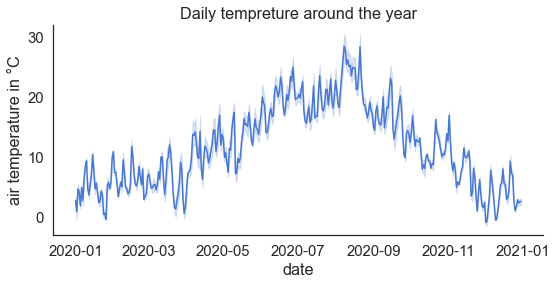

In [29]:
# Daily tempreture around the year
sns.relplot(data=BL_year, x='date', y='temp', kind='line',
            height=4, aspect=2)
plt.title('Daily tempreture around the year')
plt.xlabel('date') 
plt.ylabel('air temperature in °C')
plt.show()

As we can see from the graph above, the temperatures are higher from July to September and lower at the beginning and end of the year. This is in line with what we would expect, as temperatures change regularly with the seasons.

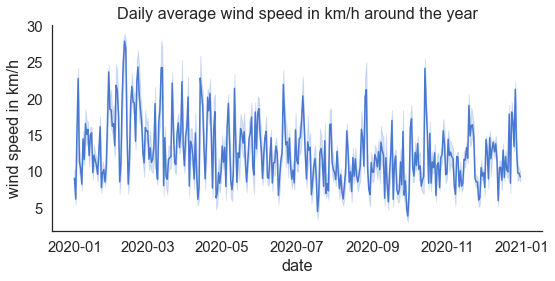

In [30]:
# Daily average wind speed in km/h around the year
sns.relplot(data=BL_year, x='date', y='wspd', kind='line',
            height=4, aspect=2)
plt.title('Daily average wind speed in km/h around the year')
plt.xlabel('date') 
plt.ylabel('wind speed in km/h')
plt.show()

We chose wind speed as a factor for analysis because airborne pollutants are made up of a variety of particulate matter. Wind speed may have a more pronounced effect on their concentrations. It is reasonable to suspect that when wind speed is high, the concentration of pollutants will be relatively low. As can be seen from the graph, wind speed fluctuates significantly throughout the year with no clear temporal pattern.

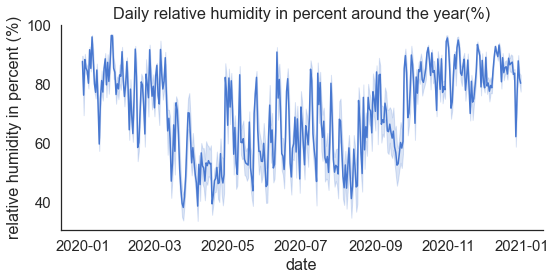

In [31]:
# Daily relative humidity in percent around the year(%)
sns.relplot(data=BL_year, x='date', y='rhum', kind='line',
            height=4, aspect=2)
plt.title('Daily relative humidity in percent around the year(%)')
plt.xlabel('date') 
plt.ylabel('relative humidity in percent (%)')
plt.show()

The diagram shows the pattern that the air humidity is higher in Berlin in winter and summer and relatively lower in spring and autumn.

### Exploring the effect of weather conditions on pollutant concentrations through linear regression
Having observed changes in each of the three main factors representing weather conditions over the course of a year, we attempted to combine the three factors to explore the effect of weather on pollutant concentrations. ***We assumed a simple linear relationship between pollutant concentrations and the three factors.*** The following section will show how the results were analysed by fitting together. We will do this in the following by three steps.

* Remember we currently only have hourly data for each day, the data need to be aggregated to each day.

* Calculate the coefficient of fit and the error of fitting model.

* Plot the pollutant concentration curves and the fitted curves on a single graph for comparison.

In [32]:
# Get daily data on NO2 in Berlin
X_Berlin = BL[['temp','rhum','wspd']]
y_Berlin_all = AQ_Germany_BL[['mydate','NO2_avg']]
y_Berlin = y_Berlin_all.groupby('mydate')['NO2_avg'].mean()
X_Berlin
y_Berlin = pd.DataFrame(y_Berlin) #Converting daily no2 concentration data into a dataframe
y_Berlin = y_Berlin.rename_axis('mydate').reset_index()
y_Berlin

,mydate,NO2_avg
0,2020-01-01,38.939375
1,2020-01-02,32.858750
2,2020-01-03,23.688125
3,2020-01-04,10.113437
4,2020-01-05,12.270000
...,...,...
337,2020-12-24,11.331250
338,2020-12-25,7.615312
339,2020-12-26,12.508750
340,2020-12-27,9.302188


### Display training set

In [33]:
# Prepare data for modelling
fit_data_Berlin = pd.merge(X_Berlin,y_Berlin,right_on='mydate',left_index=True,how='right')
X_fit_Berlin = fit_data_Berlin[['temp','rhum','wspd']]
X_fit_Berlin

,temp,rhum,wspd
0,2.7,87.8,9.0
1,0.9,76.3,6.2
2,4.6,88.4,15.3
3,4.1,85.4,22.8
4,1.8,84.5,11.3
...,...,...,...
337,6.9,87.5,18.2
338,2.7,83.3,16.9
339,1.0,83.8,13.4
340,1.6,62.2,21.3


In [34]:
y_fit_Berlin = fit_data_Berlin['NO2_avg'] 
y_fit_Berlin

0      38.939375
1      32.858750
2      23.688125
3      10.113437
4      12.270000
         ...    
337    11.331250
338     7.615312
339    12.508750
340     9.302188
341    14.950000
Name: NO2_avg, Length: 342, dtype: float64

### Show fitting results and errors

In [35]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit model and show results
modelRegL = LinearRegression()  
modelRegL.fit(X_fit_Berlin, y_fit_Berlin)  
y_pred = np.dot(X_fit_Berlin,modelRegL.coef_)+modelRegL.intercept_
print("Intercept:",modelRegL.intercept_)
print("Ceofficient for temp, rhum and wspd:",modelRegL.coef_)
error= (y_pred - y_fit_Berlin)**2
print("MSE: ",mean_squared_error(y_pred, y_fit_Berlin))

Intercept: 34.89284084856226
Ceofficient for temp, rhum and wspd: [-0.21181208 -0.06614168 -0.85610895]
MSE:  66.49662035004674


**The results show that:**



* The coefficients for temperature, humidity and wind speed are -0.21181208, -0.06614168 and -0.85610895, respectively. This indicates that the effect of humidity on pollutants is almost negligible, while wind speed largely influences the concentration of pollutants.

* The error from the fit, as measured by mse, can be seen to be relatively large, suggesting that the linear regression makes a less good fit than we would expect.

We will show the pollutant concentration curves and fitted curves below for a more in-depth analysis.

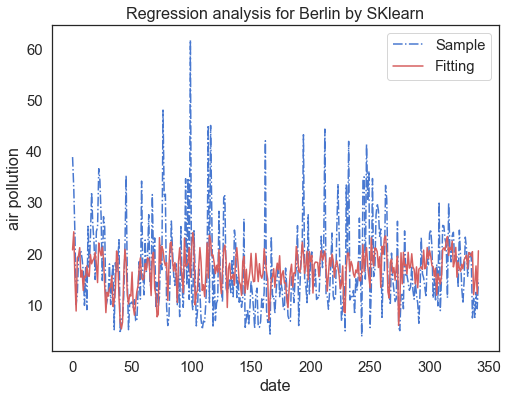

In [36]:
#Draw the original curve and the fitted curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(y_fit_Berlin)),  y_fit_Berlin, 'b-.', label='Sample') 
ax.plot(range(len(y_fit_Berlin)), y_pred, 'r-', label='Fitting') 
ax.legend(loc='best') 
plt.title('Regression analysis for Berlin by SKlearn')
plt.xlabel('date')
plt.ylabel('air pollution')
plt.show()


**Conclusion:**

It can be seen from the above figure that for the whole city of Berlin, the data noise is too large, resulting in poor linear fitting effect. From the fitting coefficient, there is a positive or negative linear relationship between each weather factor and NO2 concentration. No2 concentration is inversely proportional to temperature, humidity and wind speed.

So we have two conjectures here:

* It is true that there is no obvious linear relationship between weather and concentration, and other relationships may exist;

* Large data differences between 16 data monitoring points (location) lead to poor fitting effect.

## Is the difference in the geographical location of the observatory causing a poor fit?

---

Although the data from individual monitoring stations in the same city is likely to vary considerably. In order to exclude the influence of location on the judgement of weather conditions on pollutant concentrations, a particular monitoring station will be selected and the above tests will be re-test. Due to the missing data of too many locations, we chose the monitoring point with the code of `Location: DEBE034` for the test here.

### Display training set

In [37]:
# Set time period 
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31, 23, 59)

# Get nearby weather stations for location = DEBE034	
stations = Stations()
stations = stations.nearby(52.489451, 13.430844)
station_034 = stations.fetch(1)

# Get hourly data for DEBE061 in Berlin
BL_034 = Hourly(station_034, start, end)
BL_034 = BL_034.fetch()

BL_034

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-01-01 00:00:00,2.9,0.5,84.0,0.0,NaN,280.0,13.0,24.1,1033.3,NaN,2.0
2020-01-01 01:00:00,2.5,0.2,85.0,0.0,NaN,277.0,13.0,24.1,1033.4,NaN,2.0
2020-01-01 02:00:00,2.2,0.3,87.0,0.0,NaN,272.0,11.1,22.2,1033.4,NaN,2.0
2020-01-01 03:00:00,1.6,0.0,89.0,0.0,NaN,272.0,11.1,20.4,1033.3,NaN,1.0
2020-01-01 04:00:00,1.4,0.1,91.0,0.0,NaN,269.0,11.1,20.4,1033.3,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,1.4,-0.4,88.0,0.0,NaN,156.0,13.0,20.4,1006.2,NaN,4.0
2020-12-31 20:00:00,1.2,-0.4,89.0,0.0,NaN,158.0,11.1,20.4,1006.2,NaN,4.0
2020-12-31 21:00:00,1.3,-0.5,88.0,0.0,NaN,154.0,11.1,20.4,1006.4,NaN,4.0


In [40]:
AQ_034 = AQ_Germany_BL.query("location =='DEBE034'")
AQ_034

,mydate,location,latitude,longitude,NO2_min,NO2_max,NO2_avg,SO2_min,SO2_max,SO2_avg,PM10_min,PM10_max,PM10_avg,NO2_IAQI,SO2_IAQI,PM10_IAQI,AQI
4,2020-01-01,DEBE034,52.489451,13.430844,53.56,55.19,54.375000,NaN,NaN,NaN,180.33,208.22,194.275000,67.968750,0.0,122.137500,122.137500
20,2020-01-02,DEBE034,52.489451,13.430844,39.13,39.25,39.190000,NaN,NaN,NaN,26.88,29.39,28.135000,48.987500,0.0,28.135000,48.987500
36,2020-01-03,DEBE034,52.489451,13.430844,21.71,28.15,24.930000,NaN,NaN,NaN,17.27,21.76,19.515000,31.162500,0.0,19.515000,31.162500
52,2020-01-04,DEBE034,52.489451,13.430844,13.29,14.22,13.755000,NaN,NaN,NaN,6.78,10.58,8.680000,17.193750,0.0,8.680000,17.193750
68,2020-01-05,DEBE034,52.489451,13.430844,9.62,10.20,9.910000,NaN,NaN,NaN,11.39,11.51,11.450000,12.387500,0.0,11.450000,12.387500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5317,2020-12-24,DEBE034,52.489451,13.430844,9.49,10.13,9.810000,NaN,NaN,NaN,9.72,11.72,10.720000,12.262500,0.0,10.720000,12.262500
5333,2020-12-25,DEBE034,52.489451,13.430844,9.51,10.55,10.030000,NaN,NaN,NaN,8.69,8.74,8.715000,12.537500,0.0,8.715000,12.537500
5349,2020-12-26,DEBE034,52.489451,13.430844,13.29,15.93,14.610000,NaN,NaN,NaN,8.39,9.02,8.705000,18.262500,0.0,8.705000,18.262500
5365,2020-12-27,DEBE034,52.489451,13.430844,8.52,10.01,9.265000,NaN,NaN,NaN,13.25,13.51,13.380000,11.581250,0.0,13.380000,13.380000


In [41]:
# Prepare data for modelling
X = BL_034[['temp','rhum','wspd']]
y = AQ_034[['mydate','NO2_avg']] 
fit_data = pd.merge(X,y,right_on='mydate',left_index=True,how='right')
X_fit_034 = fit_data[['temp','rhum','wspd']]
y_fit_034 = fit_data['NO2_avg'] 

### Show fitting results and errors

In [42]:
# Fit model and show results
modelRegL = LinearRegression()
modelRegL.fit(X_fit_034, y_fit_034)  
y_pred = np.dot(X_fit_034,modelRegL.coef_)+modelRegL.intercept_
print("Intercept:",modelRegL.intercept_)
print("Ceofficient for temp, rhum and wspd:",modelRegL.coef_)
error= (y_pred - y_fit_034)**2
print("MSE: ",mean_squared_error(y_pred, y_fit_034))

Intercept: 30.278747803890578
Ceofficient for temp, rhum and wspd: [-0.49641389  0.08639484 -1.09725244]
MSE:  117.74674671786762


**The results show that:**

* The value of MSE is still large, indicating that the fitting effect is not very ideal.

* The coefficients for temperature, humidity and wind speed are -0.49641389, 0.08639484 and -1.09725244, respectively. The results show that NO2 concentration is inversely proportional to temperature, slightly proportional to humidity, and inversely proportional to wind speed.

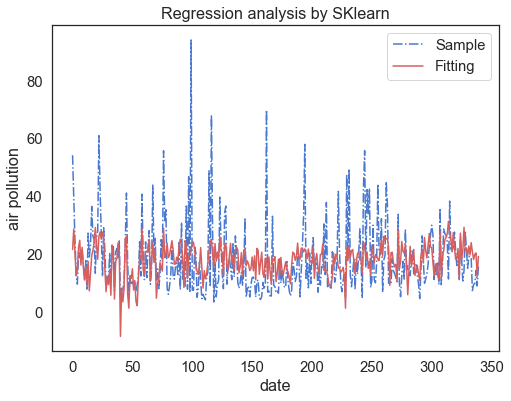

In [ ]:
# Draw the original curve and the fitted curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(y_fit_034)),  y_fit_034, 'b-.', label='Sample')  
ax.plot(range(len(y_pred)), y_pred, 'r-', label='Fitting')  
ax.legend(loc='best') 
plt.title('Regression analysis by SKlearn')
plt.xlabel('date')
plt.ylabel('air pollution')
plt.show()


**By comparing the above two regression images, the conclusion is:**

* For `Location: DEBE034`, the fitting effect is also poor, and even the value of MSE increases. This implies that it is not the difference in location that leads to a poor fitting effect for Berlin.

* For the whole city Beilin, there is a linear relationship between weather and NO2 concentration. The linear coefficient is 34.89284084856226; Because the data noise is too large, the fitting effect is not good under the influence of extreme value.


# Conclusion

---

### After investigating the data


**After exploring the air pollutants NO2, SO2 and PM10 in Berlin, Germany in OpenAQ, and observing the visualized chart, we found that:**

* At the `Location: DEBE034`, the values of NO2 concentration are relatively fluctuating, but most of the data are relatively concentrated, distributed between 0 and 30. There are also a small number of large values, relatively discrete; And its distribution also changes over time.

* After observing the histogram of NO2 concentration clustering according to month, we found that the NO2 concentration decreased significantly in summer, especially in June, while the NO2 concentration was the highest in January and September.

* Because there are too many data in Berlin, we further choose to consider more representative values, namely mean, maximum and minimum. The mean concentration of NO2 is visualized. It is observed that the mean concentration of NO2 in each location is approximately chi square distribution, generally concentrated between 0-30.

* By considering and visualizing the AQI values of 16 locations, we find that the AQI value of `Location: DEBE065` is relatively the largest in 2020_0101, and the area of the dot is relatively the largest.

**After visualizing the data of temperature, humidity and wind speed in Berlin, Germany, we find that the three influencing factors will fluctuate with time.**

* When fitting the linear relationship between NO2 concentration in Berlin and three weather factors, the value of MSE is too large, indicating that the fitting effect is not very ideal, and is inversely proportional to temperature, humidity and wind speed.

* After fitting the data of `Location: DEBE034`, we found that NO2 concentration is inversely proportional to temperature, slightly proportional to humidity, and inversely proportional to wind speed.

### Summarize the exploration

In this exploration we report on the general trends of nitrogen dioxide, sulphur dioxide and pm10 in Berlin in 2020, which show considerable variability in some areas. We therefore subsequently focused on data from one meteorological centre, `DEBE034`. In addition, we observed lower concentrations of pollutants such as nitrogen dioxide in summer and higher values in winter. Further, we evaluated the daily air quality by the AQI in the whole Berlin including its 16 locations. We assessed the combined effect of weather changes on air quality trends by means of a simple linear model.

Our exploration shows that although there is no clear linear relationship between pollutant concentrations and weather conditions in terms of temperature humidity and wind speed, a positive or negative relationship does exist here, as can be seen from the data. Thus, we suggests that when policies to further improve air quality are designed they should **consider not only the current meteorology, but also the changes in weather** likely to result from climate change.

Also, the **regional differences** identified in this exploration emphasise the need for specific regional (and seasonal) explorations to consider weather trends and source allocations of emissions of different pollutants in more detail.
